In [41]:
# Use package versions builtin to this repository.
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

# Load Flux and PlotlyJS for sweet interactive graphics
using Flux, Images, Metalhead, Random

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


┌ Warning: Some registries failed to update:
│     — /Users/sabae/.julia/registries/General — failed to fetch from repo
└ @ Pkg.API /Users/sabae/tmp/julia-build/julia-release-1.0/usr/share/julia/stdlib/v1.0/Pkg/src/API.jl:144


In [2]:
v = Metalhead.VGG19()
for idx in 1:length(v.layers.layers)
    @show v.layers[idx]
end

v.layers[idx] = Conv((3, 3), 3=>64, NNlib.relu)
v.layers[idx] = Conv((3, 3), 64=>64, NNlib.relu)
v.layers[idx] = getfield(Metalhead, Symbol("##44#50"))()
v.layers[idx] = Conv((3, 3), 64=>128, NNlib.relu)
v.layers[idx] = Conv((3, 3), 128=>128, NNlib.relu)
v.layers[idx] = getfield(Metalhead, Symbol("##45#51"))()
v.layers[idx] = Conv((3, 3), 128=>256, NNlib.relu)
v.layers[idx] = Conv((3, 3), 256=>256, NNlib.relu)
v.layers[idx] = Conv((3, 3), 256=>256, NNlib.relu)
v.layers[idx] = Conv((3, 3), 256=>256, NNlib.relu)
v.layers[idx] = getfield(Metalhead, Symbol("##46#52"))()
v.layers[idx] = Conv((3, 3), 256=>512, NNlib.relu)
v.layers[idx] = Conv((3, 3), 512=>512, NNlib.relu)
v.layers[idx] = Conv((3, 3), 512=>512, NNlib.relu)
v.layers[idx] = Conv((3, 3), 512=>512, NNlib.relu)
v.layers[idx] = getfield(Metalhead, Symbol("##47#53"))()
v.layers[idx] = Conv((3, 3), 512=>512, NNlib.relu)
v.layers[idx] = Conv((3, 3), 512=>512, NNlib.relu)
v.layers[idx] = Conv((3, 3), 512=>512, NNlib.relu)
v.layers[idx]

In [3]:
car = load("images/car.png")
dog = load("images/dog.png")
sky = load("images/sky.png");

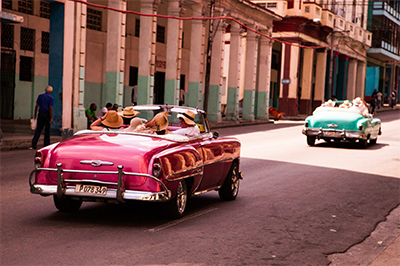

┌─────────────────────────────────────────────┐
│                                             │
├─────────────────────────────────────────────┤
│racer                 │ █████████      60.2% │
│sports car            │ █████▉         39.8% │
│car wheel             │                 0.0% │
│cab                   │                 0.0% │
│go-kart               │                 0.0% │
└─────────────────────────────────────────────┘


In [4]:
display(car)
display(predict(v, car))

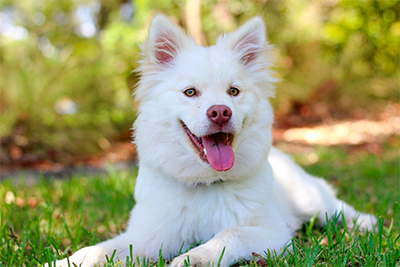

┌─────────────────────────────────────────────┐
│                                             │
├─────────────────────────────────────────────┤
│Samoyed               │ ██████████████▊98.8% │
│Eskimo dog            │                 0.5% │
│tennis ball           │                 0.2% │
│Pomeranian            │                 0.2% │
│Border collie         │                 0.1% │
└─────────────────────────────────────────────┘


In [5]:
display(dog)
display(predict(v, dog))

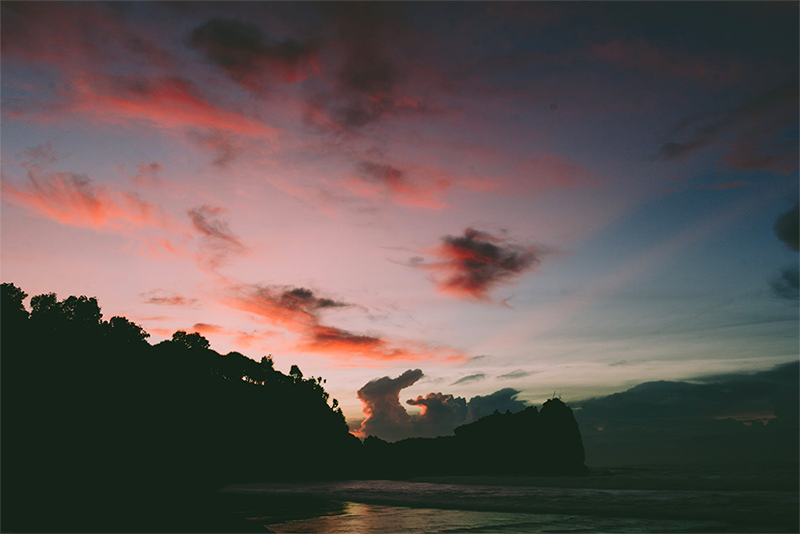

┌─────────────────────────────────────────────┐
│                                             │
├─────────────────────────────────────────────┤
│seashore              │ █████████████▏ 88.0% │
│lakeside              │ ▋               4.8% │
│castle                │ ▍               2.6% │
│church                │                 0.8% │
│beacon                │                 0.7% │
└─────────────────────────────────────────────┘


In [6]:
display(sky)
display(predict(v, sky))

In [44]:
# HD-NHD; we'll train up two dense layers on the end of the convolutional blocks
hotdog_model = Chain(
    v.layers[1:end-2]...,
    Dense(4096, 2),
    softmax,
);
opt = Flux.Optimise.ADAM(params(hotdog_model), 1e-2)

training_filenames = vcat(
    [joinpath("hotdog_train/hot_dog", f) for f in readdir("hotdog_train/hot_dog")],
    [joinpath("hotdog_train/not_hot_dog", f) for f in readdir("hotdog_train/not_hot_dog")],
)

498-element Array{String,1}:
 "hotdog_train/hot_dog/1000288.jpg"  
 "hotdog_train/hot_dog/1011661.jpg"  
 "hotdog_train/hot_dog/1013916.jpg"  
 "hotdog_train/hot_dog/1017226.jpg"  
 "hotdog_train/hot_dog/1018245.jpg"  
 "hotdog_train/hot_dog/1023510.jpg"  
 "hotdog_train/hot_dog/1040579.jpg"  
 "hotdog_train/hot_dog/1046526.jpg"  
 "hotdog_train/hot_dog/1051628.jpg"  
 "hotdog_train/hot_dog/1051643.jpg"  
 "hotdog_train/hot_dog/1051711.jpg"  
 "hotdog_train/hot_dog/1053879.jpg"  
 "hotdog_train/hot_dog/1055689.jpg"  
 ⋮                                   
 "hotdog_train/not_hot_dog/96524.jpg"
 "hotdog_train/not_hot_dog/96935.jpg"
 "hotdog_train/not_hot_dog/97656.jpg"
 "hotdog_train/not_hot_dog/98607.jpg"
 "hotdog_train/not_hot_dog/98617.jpg"
 "hotdog_train/not_hot_dog/98675.jpg"
 "hotdog_train/not_hot_dog/99010.jpg"
 "hotdog_train/not_hot_dog/99136.jpg"
 "hotdog_train/not_hot_dog/99201.jpg"
 "hotdog_train/not_hot_dog/99604.jpg"
 "hotdog_train/not_hot_dog/99890.jpg"
 "hotdog_train/not_ho

In [8]:
# Preprocess all data beforehand
training_set = Tuple[]
for idx in 1:32 #length(training_filenames)
    if idx%10 == 1
        println("[$(idx)/$(length(training_filenames))]")
    end
    filename = training_filenames[idx]
    push!(training_set, (filename, Metalhead.preprocess(filename)))
end

[1/498]
[11/498]
[21/498]
[31/498]


In [50]:
# Run training loop on test images
function train(model, opt, training_set; batch_size = 8)
    # Shuffle the training set order
    training_set = shuffle(training_set)
    
    for batch_idx in 1:batch_size:length(training_set)
        println("batch $batch_idx")
        batch = training_set[batch_idx:batch_idx+batch_size-1]
        filenames = [d[1] for d in batch]
        data = cat([d[2] for d in batch]...; dims=4)

        # Push the batch of images through the model, getting y_hat, our prediction values
        y_hat = model(data)
        
        # If the filename has `not_hot_dog` within it, we know it's not a hot dog.
        # Use this to build our known `y` vector.
        y = Int64.(occursin.(Ref("not_hot_dog"), filenames))
        y = Float64.(collect(Flux.onehotbatch(y, 0:1)))
        
        # Calculate loss and backpropagate
        loss = Flux.logitcrossentropy(y_hat .+ eps(Float64), y)
        Flux.back!(loss)
        
        @show model[end-1].W
        @show Flux.Tracker.data(y_hat)
        @show Flux.Tracker.data(loss)
        
        # Take an optimizer step
        opt()
    end
end

train(hotdog_model, opt, training_set)

batch 1


(model[end - 1]).W = Flux.Tracker.TrackedReal{Float64}[-0.0301891 (tracked) 0.0123674 (tracked) 0.0117137 (tracked) 0.0120256 (tracked) 0.0460553 (tracked) 0.00830535 (tracked) 0.0494335 (tracked) 0.0830763 (tracked) 0.0514463 (tracked) 0.0820867 (tracked) -0.0111963 (tracked) -0.0306264 (tracked) 0.00781146 (tracked) 0.0173569 (tracked) 0.0279803 (tracked) -0.0366968 (tracked) 0.0637101 (tracked) 0.0507673 (tracked) 0.0348943 (tracked) -0.0301924 (tracked) 0.0744147 (tracked) 0.039439 (tracked) 0.076924 (tracked) 0.0249484 (tracked) 0.032641 (tracked) -0.00773 (tracked) 0.0120039 (tracked) 0.0649547 (tracked) 0.0476943 (tracked) 0.0574675 (tracked) 0.0378624 (tracked) 0.0100782 (tracked) 0.00102405 (tracked) 0.0408623 (tracked) 0.0267584 (tracked) -0.0328204 (tracked) 0.059198 (tracked) -0.00156781 (tracked) 0.0527041 (tracked) 0.0589788 (tracked) 0.0252281 (tracked) 0.0247302 (tracked) -0.0181066 (tracked) -0.0359481 (tracked) 0.0742065 (tracked) -0.0335047 (tracked) 0.0272421 (track

cked) -0.0555333 (tracked) -0.0450336 (tracked) -0.0331397 (tracked) -0.0161917 (tracked) -0.0583617 (tracked) -0.0794526 (tracked) -0.0771666 (tracked) -0.0237297 (tracked) -0.0224192 (tracked) -0.050176 (tracked) -0.0794764 (tracked) -0.0508657 (tracked) 0.0115381 (tracked) -0.0163857 (tracked) -0.0176906 (tracked) -0.0210356 (tracked) -0.00305597 (tracked) 0.0362624 (tracked) -0.0617336 (tracked) -0.045688 (tracked) -0.0739871 (tracked) -0.0126642 (tracked) -0.0231408 (tracked) -0.0816982 (tracked) -0.0753593 (tracked) -0.0525588 (tracked) -0.0192732 (tracked) 0.0332073 (tracked) -0.0196412 (tracked) 7.42671e-5 (tracked) -0.0299857 (tracked) -0.0670089 (tracked) 0.0158494 (tracked) 0.0312525 (tracked) -0.0606864 (tracked) -0.028942 (tracked) 0.0272387 (tracked) -0.020426 (tracked) -0.0337593 (tracked) -0.0118042 (tracked) -0.0109736 (tracked) -0.0743623 (tracked) -0.00264035 (tracked) -0.0301882 (tracked) -0.0795734 (tracked) -0.0737119 (tracked) -0.0101574 (tracked) -0.0283146 (tra

(Flux.Tracker).data(y_hat) = [1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0; 2.3286e-107 9.44321e-147 5.25694e-184 1.44863e-132 9.12204e-122 1.64018e-135 2.25795e-167 1.85601e-131]
(Flux.Tracker).data(loss) = 0.3132616875182228
batch 9


(model[end - 1]).W = Flux.Tracker.TrackedReal{Float64}[-0.0301891 (tracked) 0.0123674 (tracked) 0.0117137 (tracked) 0.0128726 (tracked) 0.0474248 (tracked) 0.00967483 (tracked) 0.0508029 (tracked) 0.0844456 (tracked) 0.0528156 (tracked) 0.0834562 (tracked) -0.0111963 (tracked) -0.0306264 (tracked) 0.00781146 (tracked) 0.0173569 (tracked) 0.0287817 (tracked) -0.0366968 (tracked) 0.0650796 (tracked) 0.0521368 (tracked) 0.0362638 (tracked) -0.0301924 (tracked) 0.0757841 (tracked) 0.040661 (tracked) 0.0782934 (tracked) 0.0263175 (tracked) 0.0340105 (tracked) -0.00773 (tracked) 0.0133734 (tracked) 0.0663241 (tracked) 0.0489014 (tracked) 0.0580936 (tracked) 0.0385493 (tracked) 0.0114477 (tracked) 0.00131795 (tracked) 0.0422318 (tracked) 0.0267584 (tracked) -0.0328204 (tracked) 0.0605675 (tracked) -0.00156781 (tracked) 0.0540736 (tracked) 0.0603482 (tracked) 0.0256851 (tracked) 0.0247302 (tracked) -0.0181066 (tracked) -0.0359481 (tracked) 0.075576 (tracked) -0.0335047 (tracked) 0.0286115 (tra

d) -0.034509 (tracked) -0.0175611 (tracked) -0.0597312 (tracked) -0.080822 (tracked) -0.0785361 (tracked) -0.0250992 (tracked) -0.0237887 (tracked) -0.0514494 (tracked) -0.0808459 (tracked) -0.0522351 (tracked) 0.0115381 (tracked) -0.0177552 (tracked) -0.0176906 (tracked) -0.0210356 (tracked) -0.00305597 (tracked) 0.0362624 (tracked) -0.0631031 (tracked) -0.0470474 (tracked) -0.0753565 (tracked) -0.0126642 (tracked) -0.0245103 (tracked) -0.0829521 (tracked) -0.0767288 (tracked) -0.0538063 (tracked) -0.0206427 (tracked) 0.0331999 (tracked) -0.0210107 (tracked) 7.42671e-5 (tracked) -0.0299857 (tracked) -0.0683783 (tracked) 0.0158494 (tracked) 0.0312525 (tracked) -0.0620559 (tracked) -0.0302202 (tracked) 0.0272387 (tracked) -0.020426 (tracked) -0.0351288 (tracked) -0.0118042 (tracked) -0.0109736 (tracked) -0.0754458 (tracked) -0.00269693 (tracked) -0.0303738 (tracked) -0.0809429 (tracked) -0.0750814 (tracked) -0.0115269 (tracked) -0.0289067 (tracked) -0.0240988 (tracked) 0.00828302 (track

(Flux.Tracker).data(y_hat) = [1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0; 4.42505e-243 5.39408e-133 6.32232e-119 5.04861e-136 3.13757e-143 2.60719e-161 5.33348e-135 1.88288e-184]
(Flux.Tracker).data(loss) = 0.3132616875182228
batch 17


(model[end - 1]).W = Flux.Tracker.TrackedReal{Float64}[-0.0301891 (tracked) 0.0123674 (tracked) 0.0117137 (tracked) 0.0136202 (tracked) 0.048662 (tracked) 0.010912 (tracked) 0.0520401 (tracked) 0.0856826 (tracked) 0.0540525 (tracked) 0.0846934 (tracked) -0.0111963 (tracked) -0.0306264 (tracked) 0.00781146 (tracked) 0.0173569 (tracked) 0.0294879 (tracked) -0.0366968 (tracked) 0.0663168 (tracked) 0.053374 (tracked) 0.037501 (tracked) -0.0301924 (tracked) 0.0770213 (tracked) 0.0417564 (tracked) 0.0795307 (tracked) 0.0275543 (tracked) 0.0352477 (tracked) -0.00773 (tracked) 0.0146106 (tracked) 0.0675613 (tracked) 0.0499827 (tracked) 0.0586427 (tracked) 0.0391525 (tracked) 0.0126849 (tracked) 0.00157417 (tracked) 0.043469 (tracked) 0.0267584 (tracked) -0.0328204 (tracked) 0.0618047 (tracked) -0.00156781 (tracked) 0.0553108 (tracked) 0.0615854 (tracked) 0.0260844 (tracked) 0.0247302 (tracked) -0.0181066 (tracked) -0.0359481 (tracked) 0.0768131 (tracked) -0.0335047 (tracked) 0.0298487 (tracked

racked) -0.0187984 (tracked) -0.0609684 (tracked) -0.0820592 (tracked) -0.0797733 (tracked) -0.0263363 (tracked) -0.0250259 (tracked) -0.0525938 (tracked) -0.0820831 (tracked) -0.0534724 (tracked) 0.0115381 (tracked) -0.0189923 (tracked) -0.0176906 (tracked) -0.0210356 (tracked) -0.00305597 (tracked) 0.0362624 (tracked) -0.0643403 (tracked) -0.0482749 (tracked) -0.0765937 (tracked) -0.0126642 (tracked) -0.0257475 (tracked) -0.0840779 (tracked) -0.077966 (tracked) -0.0549259 (tracked) -0.0218799 (tracked) 0.0331934 (tracked) -0.0222479 (tracked) 7.42671e-5 (tracked) -0.0299857 (tracked) -0.0696156 (tracked) 0.0158494 (tracked) 0.0312525 (tracked) -0.0632931 (tracked) -0.0313691 (tracked) 0.0272387 (tracked) -0.020426 (tracked) -0.036366 (tracked) -0.0118042 (tracked) -0.0109736 (tracked) -0.0764108 (tracked) -0.00274617 (tracked) -0.0305354 (tracked) -0.0821801 (tracked) -0.0763185 (tracked) -0.0127641 (tracked) -0.0294255 (tracked) -0.025336 (tracked) 0.00828302 (tracked) -0.015535 (tr

Excessive output truncated after 570788 bytes.

(Flux.Tracker).data(y_hat) = [1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0; 1.93869e-170 1.66228e-172 3.68391e-146 1.84776e-139 1.60549e-217 7.00423e-148 2.38023e-173 7.54806e-164]
(Flux.Tracker).data(loss) = 0.3132616875182228
batch 25


In [46]:
hotdog_model(Metalhead.preprocess("hotdog_test/hot_dog/139177.jpg"))

Tracked 2×1 Array{Float64,2}:
 1.0                  
 6.010514414866963e-68

In [47]:
hotdog_model(Metalhead.preprocess("hotdog_test/not_hot_dog/7056.jpg"))

Tracked 2×1 Array{Float64,2}:
 1.0                  
 7.417612480369685e-80

In [36]:
hotdog_model

Chain(Conv((3, 3), 3=>64, NNlib.relu), Conv((3, 3), 64=>64, NNlib.relu), getfield(Metalhead, Symbol("##44#50"))(), Conv((3, 3), 64=>128, NNlib.relu), Conv((3, 3), 128=>128, NNlib.relu), getfield(Metalhead, Symbol("##45#51"))(), Conv((3, 3), 128=>256, NNlib.relu), Conv((3, 3), 256=>256, NNlib.relu), Conv((3, 3), 256=>256, NNlib.relu), Conv((3, 3), 256=>256, NNlib.relu), getfield(Metalhead, Symbol("##46#52"))(), Conv((3, 3), 256=>512, NNlib.relu), Conv((3, 3), 512=>512, NNlib.relu), Conv((3, 3), 512=>512, NNlib.relu), Conv((3, 3), 512=>512, NNlib.relu), getfield(Metalhead, Symbol("##47#53"))(), Conv((3, 3), 512=>512, NNlib.relu), Conv((3, 3), 512=>512, NNlib.relu), Conv((3, 3), 512=>512, NNlib.relu), Conv((3, 3), 512=>512, NNlib.relu), getfield(Metalhead, Symbol("##48#54"))(), getfield(Metalhead, Symbol("##49#55"))(), Dense(25088, 4096, NNlib.relu), Dropout{Float32}(0.5f0, false), Dense(4096, 4096, NNlib.relu), Dropout{Float32}(0.5f0, false), Dense(4096, 2), NNlib.softmax)